<div align="center" style="line-height: 1.7;">
    <h2 style="font-weight: 600;"><strong>Dyna-Q in GridWorld</strong></h2>
</div> 

&nbsp;

**Goal:** Learn a high-quality policy by combining **real experience** (TD control) with planning from a learned **one-step model**.

---

### Why Dyna-Q?
**Dyna-Q** augments standard model-free learning (like Q-Learning) with **simulated updates** drawn from a simple learned model **$M$** of the environment. After each real step, it performs **$K$ planning updates** by sampling previously seen $(s, a)$ pairs, querying **$M$** for $(r, s', done)$, and applying the **same TD backup** you'd use on real data. This typically improves **sample efficiency** (faster learning in fewer real steps).

---

### Interaction Loop (real + planning)
At each time step the agent:

1. Observes current state $(s)$
2. Chooses action $(a \sim \pi_\epsilon(\cdot \mid s)$ $(\varepsilon\text{-greedy})$
3. Receives reward $(r)$, transitions to $(s')$ (real environment)
4. **Real TD update** on $Q(s, a)$
5. **Model Update:** store / refresh  $\hat{r}(s, a), \hat{s}'(s, a), \hat{d}(s, a)$
6. **Planning:** for $(K = 1...K)$, sample a previously seen $(\tilde{s}, \tilde{a})$, query the model for $(\tilde{r}, \tilde{s}', \tilde{d})$, and apply a TD update to $Q(\tilde{s}, \tilde{a})$

The **return** is the discounted sum of future rewards,

$$
G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}
$$

with discount $\gamma \in [0, 1]$ controlling farsightedness.

---

### Action-Value Function & Backup

Dyna-Q learns the **action-value function** $Q(s, a)$: expected return starting ini $(s)$, taking $(a)$, and thereafter following the (greedy/$\varepsilon\text{-greedy}$) control policy.
We use the **Q-Learning (off-policy) target** for both real and model steps:

$$
\boxed{~~
Q(s, a) \leftarrow Q(s, a) + \alpha \Big[\, r + \gamma \max{a'} Q(s', a') - Q(s, a) \, \Big]
~~}
$$

- **Real update:** $(s, a, r, s', d)$ comes from the environment.
- **Planning update(s):** $(\tilde{s}, \tilde{a}, \tilde{r}, \tilde{s}', \tilde{d})$ come from the **model** $(\hat{\mathcal M})$

If we had the true optimal $Q^\star$, the greedy action would be

$$
\pi^\star(s) = \arg\max_a Q^\star(s, a).
$$

---

### Symbol

| Symbol | Meaning |
|---|---|
| $(s, a)$ | Current state and action |
| $(r)$ | Reward after taking $(a)$ in $(s)$ |
| $(s')$ | Next state |
| $(\alpha)$ | Learning rate |
| $(\gamma)$ | Discount factor |
| $(K)$ | `planning_steps`: number of simulated updates per real step |
| $(\hat{\mathcal M})$ | Learned one-step model storing last-seen $(r, s', \text{done}$ per $(s,a)$ |
| TD error | $\delta = r + \gamma \max_{a'} Q(s',a') - Q(s,a)$ |

---


### Exploration vs Exploitation

Behavior policy is **$\varepsilon\text{-greedy}$:**

- With probability $(\epsilon)$: pick a random action (explore)
- With probability $(1 - \epsilon)$: pick $\arg\max_a Q(s, a)$ (exploitation)

$(\epsilon)$ typically **decays** from 1.0 to a small floor so early training explores widely and later focuses on exploitation.

---

### Intuitive Summary

| Concept | Analogy |
|---|---|
| Q-table | A map: how good each move is in each state |
| Model \(\hat{\mathcal M}\) | A notebook of “what happened last time we tried \((s,a)\)” |
| Planning | “Imaginary practice” using the notebook to reinforce the map |
| TD Error | Surprise: how different reality/model was from our prediction |
| \(K\) (planning steps) | How many extra practice reps per real step |

**Heuristic.** With a modest $(K)$ (e.g., 5–20), Dyna-Q often reaches strong policies **sooner** than pure Q-Learning, especially when real interactions are costly. Larger $(K)$ speeds early learning but can overemphasize stale model entries balance is key.

### 1) Import & Environment Setup

In [1]:
# --- Imports & setup --------------------------------------------------------
import os, sys, numpy as np
import matplotlib.pyplot as plt

# repo: /notebooks + /src
sys.path.append(os.path.abspath("../src"))

from rl_capstone.gridworld import GridWorld, WorldSettings
from rl_capstone.rl_algorithms import TrainConfig, dyna_q_with_logs
import rl_capstone.utils as U  # set_seed, init_q_table, epsilon_greedy_action, greedy_policy_from_0, evaluate_policy

# pretty prints
GREEN = "\033[92m"; RED = "\033[91m"; RESET = "\033[0m"
print(f"{GREEN}Imports ready.{RESET}")


Imports ready.


### 2) Build & Preview the environment

States=121, Actions=4, Grid=11x11


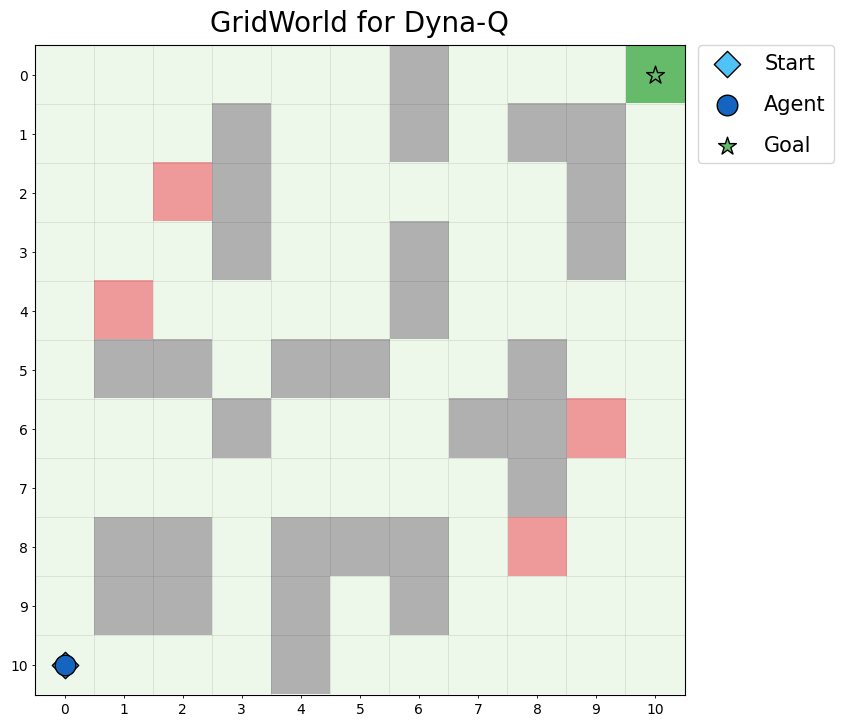

In [2]:
settings = WorldSettings()  # same map you used before
env = GridWorld(settings)
env.seed(7)
print(f"States={env.num_states}, Actions={env.num_actions}, Grid={env.rows}x{env.cols}")

env.render(title="GridWorld for Dyna-Q")


### 3) Trainer (Dyna-Q with logs + snapshots)

In [3]:
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Optional

@dataclass
class LogConfig:
    snapshot_every: int = 40
    eval_episodes: int = 5
    seed: Optional[int] = 7

def _epsilon(t: int, cfg: TrainConfig) -> float:
    if cfg.eps_decay_steps <= 0:
        return cfg.eps_end
    frac = min(1.0, max(0.0, t / cfg.eps_decay_steps))
    return (1.0 - frac) * cfg.eps_start + frac * cfg.eps_end

def run_greedy_episode(env, Q: np.ndarray, max_steps=1000):
    # tie-break uniformly among argmax actions
    def greedy_action(Q, s):
        row = Q[s]; m = np.max(row)
        choices = np.flatnonzero(np.isclose(row, m))
        return int(np.random.choice(choices))
    s = env.reset()
    G, traj = 0.0, [s]
    for _ in range(max_steps):
        a = greedy_action(Q, s)
        s2, r, done, _ = env.step(a)
        G += r; traj.append(s2); s = s2
        if done: break
    return G, traj

# def dyna_q_with_logs(env, cfg: TrainConfig, logcfg: LogConfig) -> Tuple[np.ndarray, Dict[str, Any]]:
#     """
#     Dyna-Q:
#       - real TD updates (Q-learning target)
#       - learned one-step model: last-seen (r, s', done) per (s,a)
#       - K planning updates per real step: cfg.planning_steps
#     Returns: Q and logs dict with returns, steps, snapshots.
#     """
#     rng = U.set_seed(cfg.seed)
#     S, A = env.num_states, env.num_actions
#     Q = U.init_q_table(S, A, cfg.q_init)

#     model: Dict[Tuple[int,int], Tuple[float,int,bool]] = {}
#     visited: List[Tuple[int,int]] = []

#     def _update_Q(s: int, a: int, r: float, s2: int, done: bool):
#         td_target = r + cfg.gamma * (0.0 if done else np.max(Q[s2]))
#         Q[s, a] += cfg.alpha * (td_target - Q[s, a])

#     returns, steps, snapshots = [], [], []
#     step_count = 0

#     for ep in range(cfg.episodes):
#         s = env.reset()
#         G, ep_steps = 0.0, 0

#         for _ in range(cfg.max_steps):
#             a = U.epsilon_greedy_action(Q, s, _epsilon(step_count, cfg), rng)

#             # real step
#             s2, r, done, _ = env.step(a)
#             _update_Q(s, a, r, s2, done)

#             # update model memory
#             if (s, a) not in model:
#                 visited.append((s, a))
#             model[(s, a)] = (r, s2, done)

#             # planning
#             K = getattr(cfg, "planning_steps", 20)
#             for _k in range(K):
#                 si, ai = visited[int(rng.integers(len(visited)))]
#                 ri, s2i, di = model[(si, ai)]
#                 _update_Q(si, ai, ri, s2i, di)

#             s = s2
#             G += r
#             ep_steps += 1
#             step_count += 1
#             if done:
#                 break

#         returns.append(G)
#         steps.append(ep_steps)

#         # snapshots for later rendering
#         take = (ep == 0) or ((ep + 1) % logcfg.snapshot_every == 0) or (ep == cfg.episodes - 1)
#         if take:
#             eval_returns = []
#             for _ in range(logcfg.eval_episodes):
#                 Ge, _traj = run_greedy_episode(env, Q, max_steps=cfg.max_steps)
#                 eval_returns.append(Ge)
#             snapshots.append({"episode": ep + 1, "avg_return": float(np.mean(eval_returns)), "Q": Q.copy()})

#     logs = {"returns": np.array(returns), "steps": np.array(steps), "snapshots": snapshots}
#     return Q, logs


### 4) Train + plot learning curve

Dyna-Q training done.


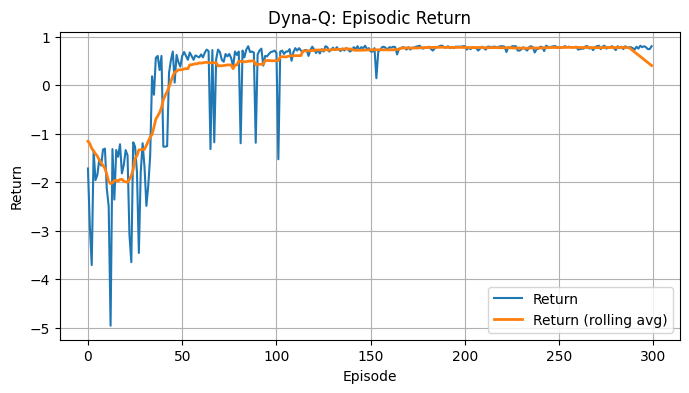

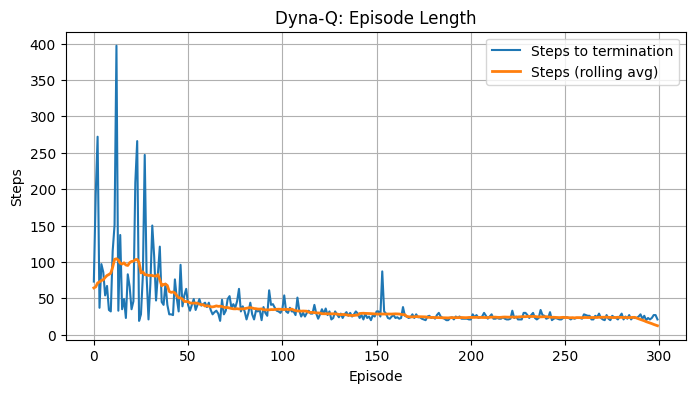

In [4]:
# same constants as Q-Learning / SARSA (plus planning_steps)
cfg = TrainConfig(
    episodes=300, max_steps=600,
    alpha=0.15, gamma=0.99,
    eps_start=1.0, eps_end=0.05, eps_decay_steps=8_000,
    seed=3, q_init=0.0,
    planning_steps=20
)
logcfg = LogConfig(snapshot_every=40, eval_episodes=5, seed=7)

Q_dyna, logs_dyna = dyna_q_with_logs(env, cfg, logcfg)
print("Dyna-Q training done.")

# rolling helper (same style)
def rolling(x, k=25):
    x = np.asarray(x, dtype=float)
    if k <= 1 or k > len(x): return x
    w = np.ones(k)/k
    return np.convolve(x, w, mode="same")

plt.figure(figsize=(8,4))
plt.plot(logs_dyna["returns"], label="Return")
plt.plot(rolling(logs_dyna["returns"], 25), label="Return (rolling avg)", linewidth=2)
plt.title("Dyna-Q: Episodic Return"); plt.xlabel("Episode"); plt.ylabel("Return")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(logs_dyna["steps"], label="Steps to termination")
plt.plot(rolling(logs_dyna["steps"], 25), label="Steps (rolling avg)", linewidth=2)
plt.title("Dyna-Q: Episode Length"); plt.xlabel("Episode"); plt.ylabel("Steps")
plt.grid(True); plt.legend(); plt.show()


### 5) Render snapshot trajectories

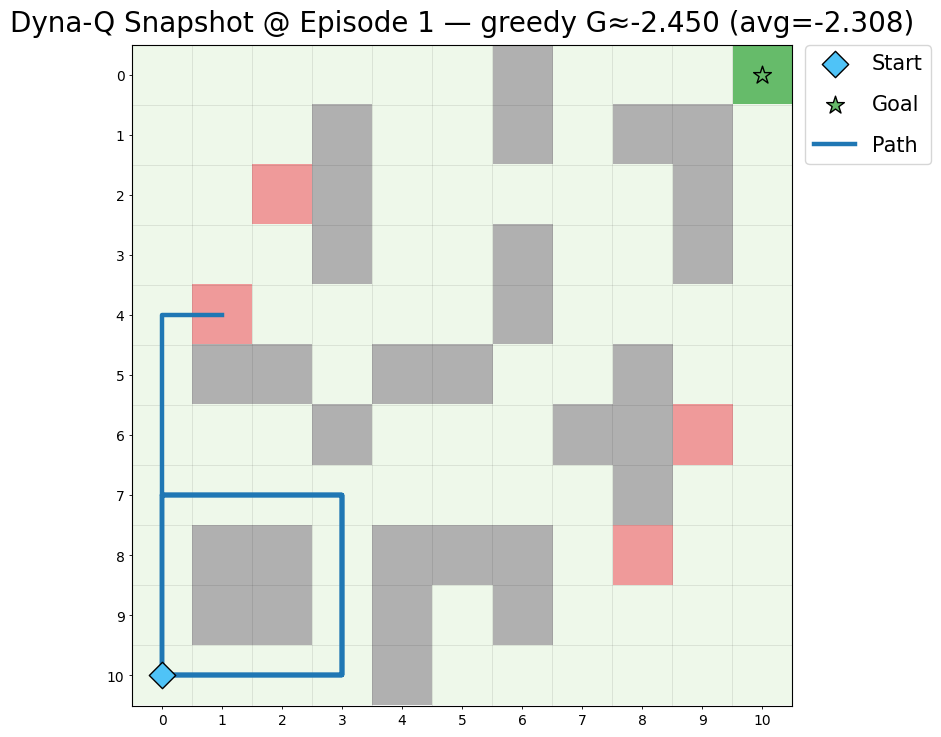

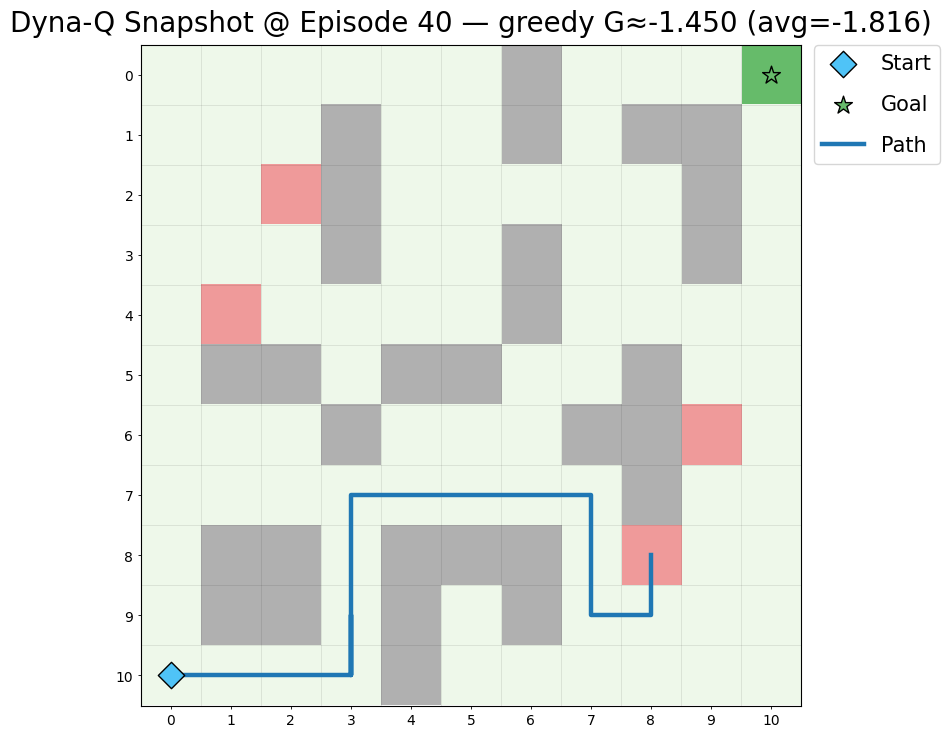

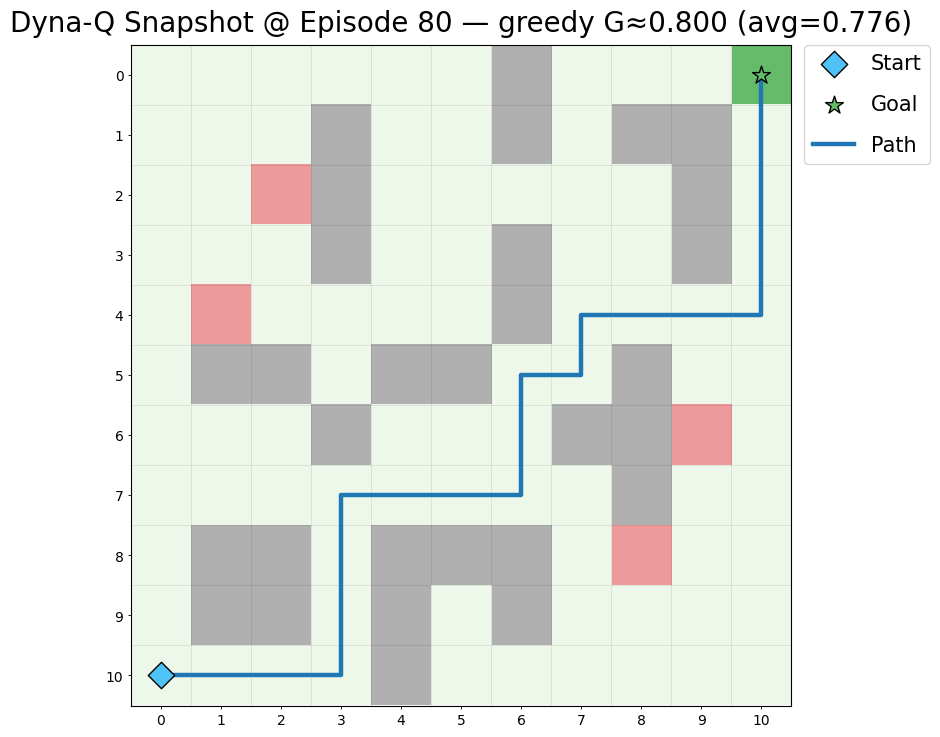

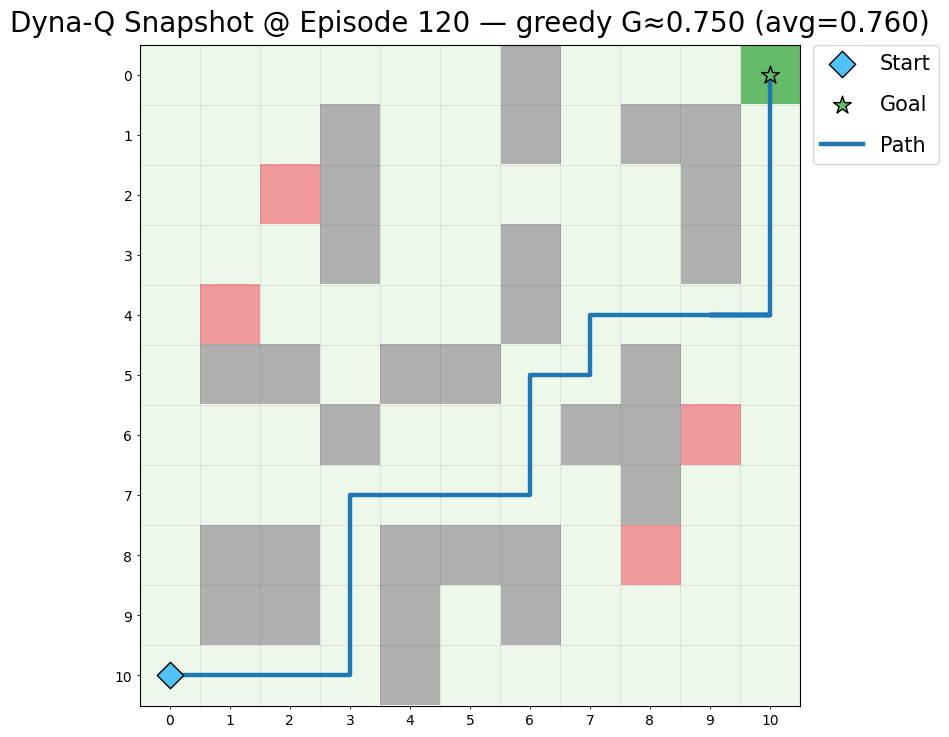

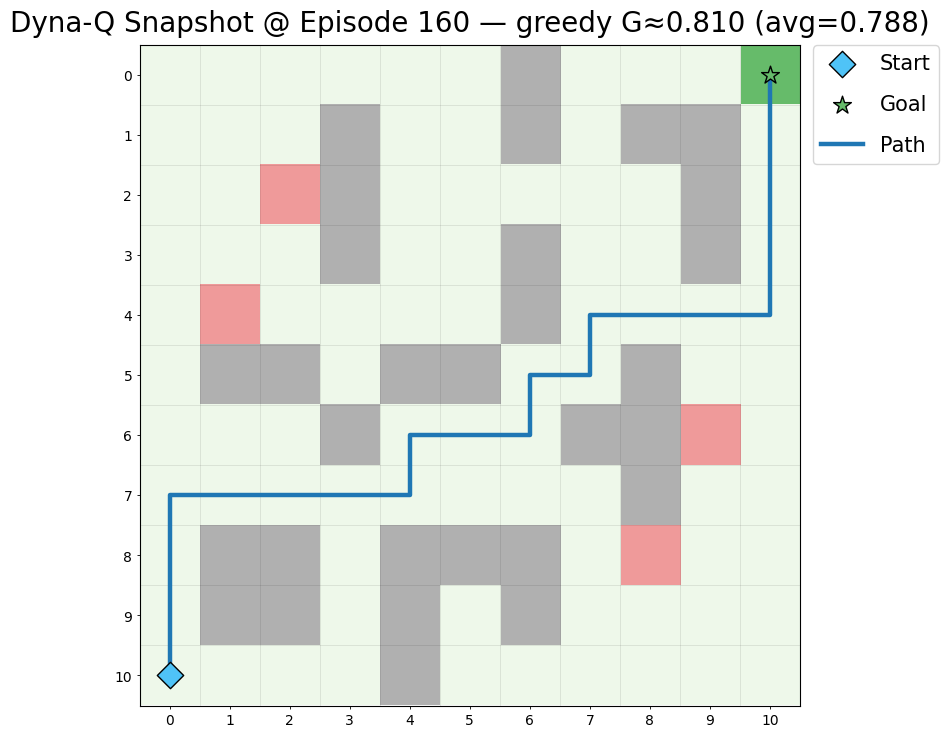

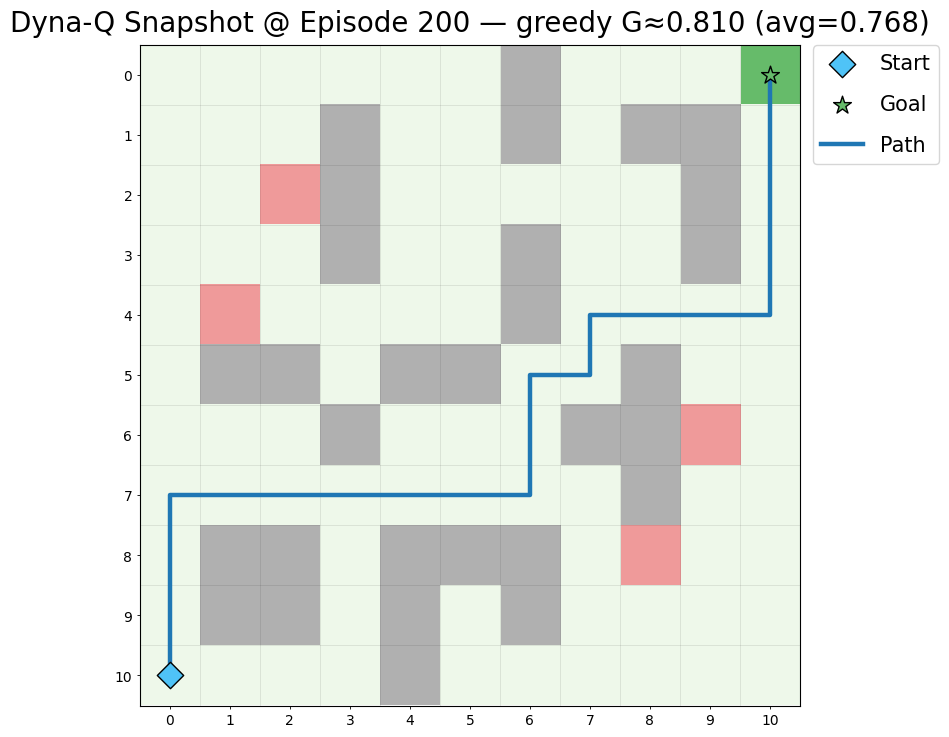

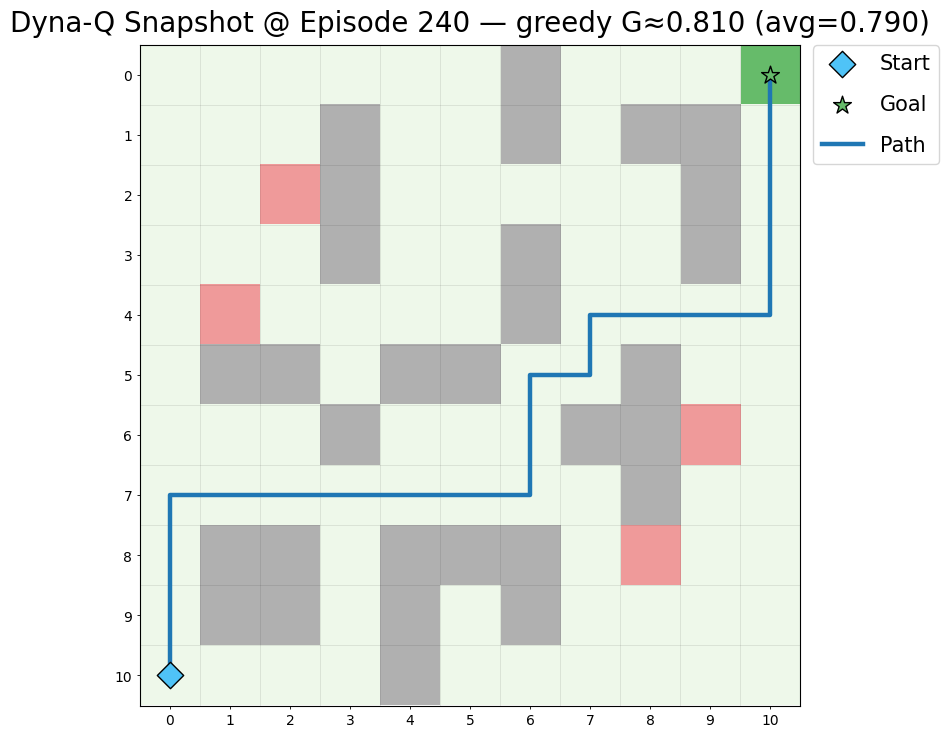

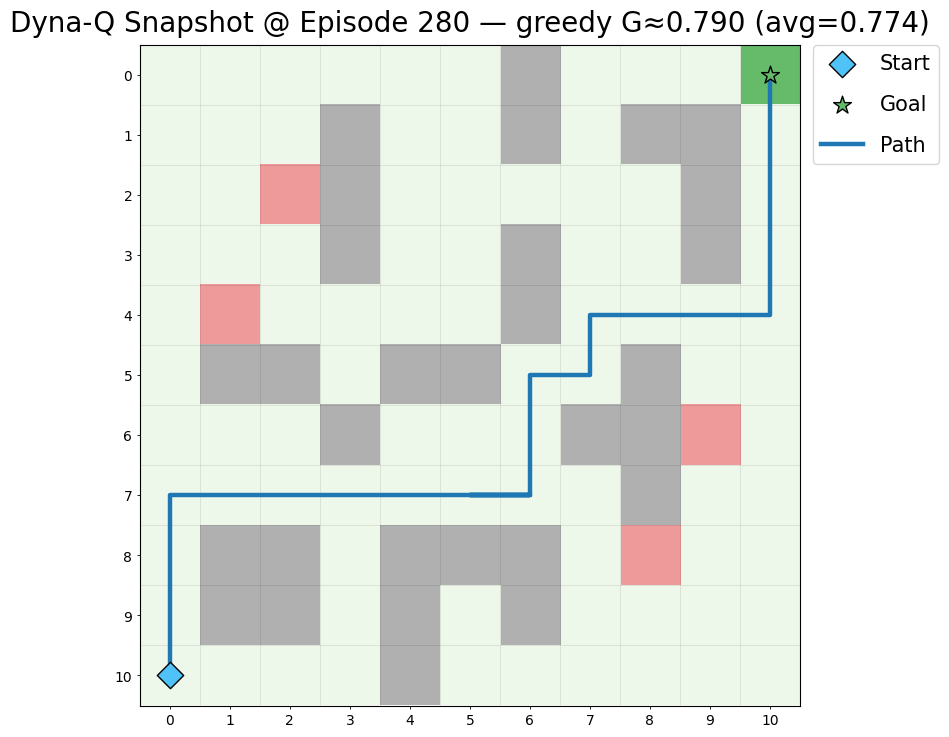

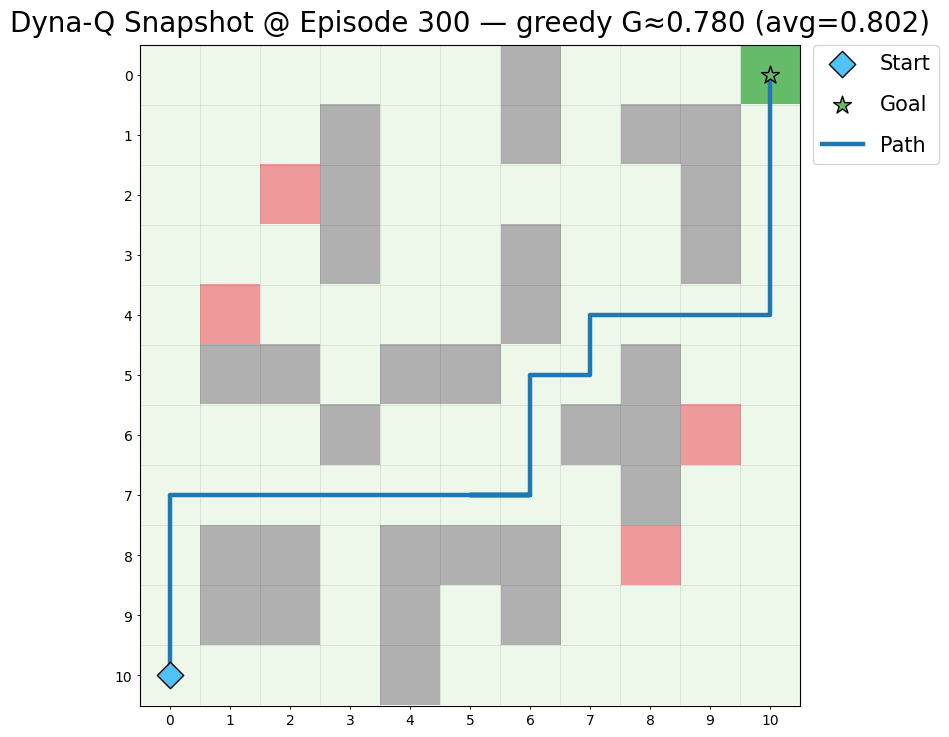

In [5]:
def idx_traj_to_rc_path(env, traj_idx):
    return [env._to_pos(s) for s in traj_idx]

# snapshots
for snap in logs_dyna["snapshots"]:
    ep = snap["episode"]; Q_snap = snap["Q"]; avg_ret = snap["avg_return"]
    G_snap, traj_idx = run_greedy_episode(env, Q_snap, max_steps=cfg.max_steps)
    env.reset()
    env.render(
        path=idx_traj_to_rc_path(env, traj_idx),
        show_agent=False,
        title=f"Dyna-Q Snapshot @ Episode {ep} — greedy G≈{G_snap:.3f} (avg={avg_ret:.3f})"
    )


### 6) Final Path 

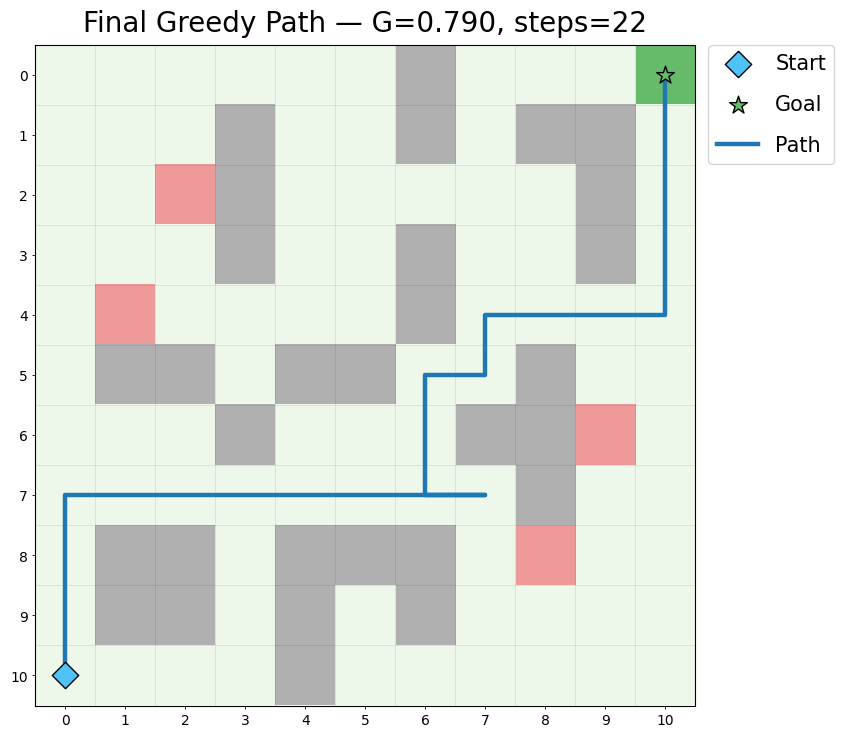

In [6]:
# final greedy path
G_final, traj_final = run_greedy_episode(env, Q_dyna, max_steps=cfg.max_steps)
env.reset()
env.render(
    path=idx_traj_to_rc_path(env, traj_final),
    show_agent=False,
    title=f"Final Greedy Path — G={G_final:.3f}, steps={len(traj_final)-1}"
)

### 7) Policy / Value Heatpmap with arrows

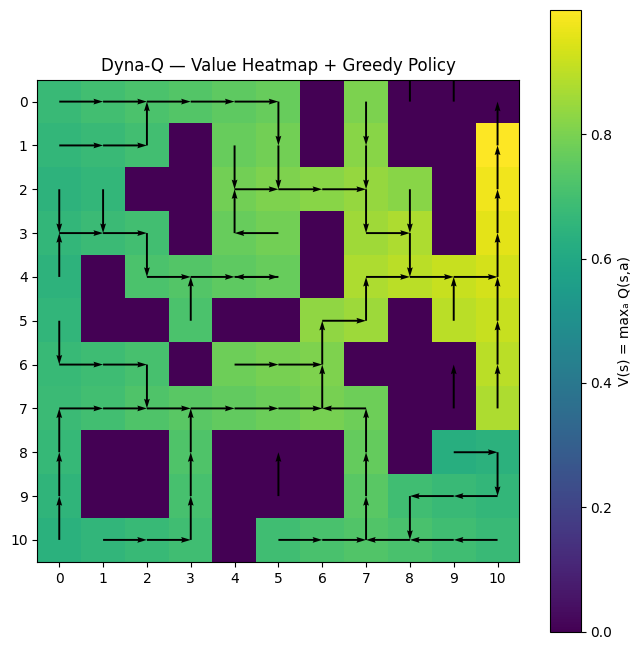

In [7]:
def value_grid(env, Q):
    V = np.max(Q, axis=1)
    Gm = np.zeros((env.rows, env.cols))
    for s in range(env.num_states):
        r, c = env._to_pos(s)
        Gm[r, c] = V[s]
    return Gm

def plot_value_and_policy(env, Q, title="Dyna-Q — Value Heatmap + Greedy Policy"):
    H, W = env.rows, env.cols
    Vg = value_grid(env, Q)

    plt.figure(figsize=(6.6, 6.6))
    plt.imshow(Vg, origin='upper')
    plt.colorbar(label="V(s) = maxₐ Q(s,a)")
    plt.title(title)
    plt.xticks(range(W)); plt.yticks(range(H))

    # arrows (0:Up, 1:Right, 2:Down, 3:Left)
    action_to_vec = {0:(-1,0), 1:(0,1), 2:(1,0), 3:(0,-1)}
    X, Y, Uv, Vv = [], [], [], []
    for s in range(env.num_states):
        r, c = env._to_pos(s)
        if env._is_wall((r, c)) or env.is_terminal((r, c)):
            continue
        a = int(np.argmax(Q[s]))
        dr, dc = action_to_vec[a]
        X.append(c); Y.append(r); Uv.append(dc); Vv.append(dr)

    plt.quiver(X, Y, Uv, Vv, scale=1, angles='xy', scale_units='xy', width=0.004)
    plt.grid(False); plt.tight_layout(); plt.show()

plot_value_and_policy(env, Q_dyna)


### Conclusion


The results highlight Dyna-Q’s defining strength as a **model-based extension** of Q-Learning that accelerates learning through simulated experience. By combining real interactions with planning updates drawn from a learned one-step model, the agent refines its policy more rapidly and achieves higher early performance than either purely model-free method.

* **Episodic Return:** Initial episodes again show strongly negative returns as the agent explores blindly. However, the learning curve for Dyna-Q rises **significantly faster** than in SARSA or Q-Learning, reflecting the benefit of additional planning updates that reinforce valuable state–action pairs even without new environmental samples. The rolling-average return stabilizes sooner, indicating that the model’s replayed transitions effectively bootstrap knowledge across similar states.

* **Episode Length:** Episode duration decreases sharply after roughly **60–80 episodes**, a much earlier improvement than observed for the other algorithms. This shows that the agent not only reaches the goal more consistently but also optimizes its route more efficiently. The reduction in episode length plateaus as the model converges, suggesting diminishing returns once most useful transitions are already captured in memory.

* **Final Policy and Value Function:** The learned value heatmap displays a **well-structured gradient** toward the goal, with clearly delineated high-value corridors that avoid pits and walls. The greedy policy arrows align into a smooth, direct path from the start to the goal region. Unlike SARSA’s slightly conservative strategy, Dyna-Q’s policy more closely resembles the **aggressive optimal** path discovered by Q-Learning, but it is achieved in far fewer real episodes thanks to its internal planning.

* **Greedy Path Visualization:** The final greedy trajectory confirms that the agent reaches the goal in approximately **20–25 steps** with average returns near **0.8–0.9**, depending on environmental stochasticity. Movements appear confident and well-coordinated, rarely backtracking or stalling. This demonstrates Dyna-Q’s hallmark feature: by integrating **model learning and simulated updates**, the agent achieves **high sample efficiencyv**, learning near-optimal behavior with substantially fewer real environment interactions than purely model-free algorithms.

---

<style>
    .button {
        background-color: #3b3b3b;
        color: white;
        padding: 25px 60px;
        border: none;
        border-radius: 12px;
        cursor: pointer;
        font-size: 30px;
        transition: background-color 0.3s ease;
    }

    .button:hover {
        background-color: #45a049;
        transform: scale(1.05);
    }
    
</style>

<div style=" text-align: center; margin-top:20px;">
    
  <a href="02_sarsa.ipynb">
    <button class="button">
      ⬅️ Prev: SARSA
    </button>
  </a>
  <span style="display:inline-block; width:200px;"></span>
  <a href="04_results.ipynb">
    <button class="button">
      Next: Results ➡️
    </button>
  </a>
  
</div>
